In [40]:
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
DIRECTORY = 'C:/Users/65848/Documents/GitHub/WOW_IHPC/YFD/archive/data/'




(243, 320, 3)


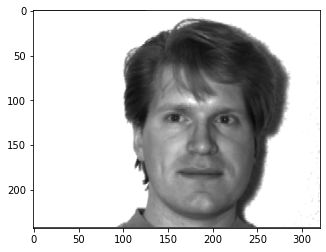

In [41]:
filename = "C:/Users/65848/Documents/GitHub/WOW_IHPC/YFD/archive/data/subject01.centerlight"
pixels = plt.imread(filename)
rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print (rgb_pixels.shape)
plt.imshow(rgb_pixels)
plt.show()

In [42]:
detector = MTCNN()
results = detector.detect_faces(rgb_pixels)
results

[{'box': [121, 69, 122, 154],
  'confidence': 0.9999041557312012,
  'keypoints': {'left_eye': (160, 122),
   'right_eye': (214, 123),
   'nose': (189, 152),
   'mouth_left': (163, 182),
   'mouth_right': (210, 184)}}]

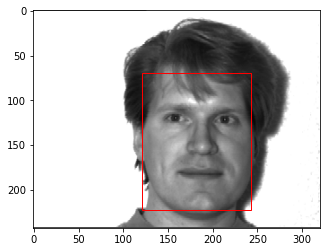

In [43]:
def draw_image_with_boxes(data, result_list):
    plt.imshow(data)
    ax = plt.gca()
    for result in result_list:
        x, y, width, height = result['box']
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    plt.show
draw_image_with_boxes(rgb_pixels, results)


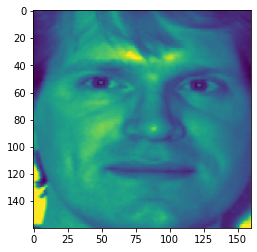

In [44]:
def extract_face_from_file (filename, required_size=(160, 160)):
    image = Image.open(filename)

    return extract_face(image, required_size)
def extract_face(image, required_size = (160, 160 )):
    image = image.convert('RGB')
    pixels = (np.asarray(image))
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1: y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)

    return gray_face
    
face_pixels = extract_face_from_file("C:/Users/65848/Documents/GitHub/WOW_IHPC/YFD/archive/data/subject01.centerlight")
plt.imshow(face_pixels)


100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


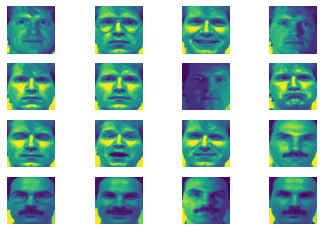

In [45]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)
i = 1
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    path = DIRECTORY + filename
    face = extract_face_from_file(path)
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.show()

In [46]:
filenames = pd.DataFrame(list_files(DIRECTORY, 'subject'))

df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames
df = df.rename(columns = {0: "subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject', '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df



,subject,category,filename
0,1,centerlight,subject01.centerlight
1,1,glasses,subject01.glasses
2,1,happy,subject01.happy
3,1,leftlight,subject01.leftlight
4,1,noglasses,subject01.noglasses
...,...,...,...
160,15,rightlight,subject15.rightlight
161,15,sad,subject15.sad
162,15,sleepy,subject15.sleepy
163,15,surprised,subject15.surprised


In [47]:
df['subject'].unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [48]:
PER_CLASS = 8
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES/DS_SIZE)
y = df['subject']
x = df.drop('subject', axis = 1)
X_train_info, X_test_info, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=45, stratify= y)
y_train = y_train.tolist()
y_test = y_test.tolist()

detector = MTCNN()
def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY + filename
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

100%|██████████| 120/120 [01:10<00:00,  1.70it/s]

(45, 160, 160)
(120, 160, 160)


In [49]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import random

In [50]:
in_encoder = Normalizer(norm = 'l2')
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
print ('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

out_encoder = LabelEncoder()
out_encoder.fit(y_train)
model = SVC(kernel="linear", probability=True)
model.fit(X_train_reshaped, y_train)
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)


print('Accuracy: train=%.3f, test=%.3f'%(score_train*100, score_test*100))

Reshaped X_train (120, 25600)
Reshaped X_test (45, 25600)
Accuracy: train=94.167, test=60.000


In [51]:
svm_predictions = model.predict(X_test_reshaped)
print(classification_report(y_test, svm_predictions))
print('Confusion Matrix:')
print(confusion_matrix(y_test, svm_predictions))

              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       0.67      0.67      0.67         3
           3       0.17      0.33      0.22         3
           4       1.00      0.67      0.80         3
           5       0.67      0.67      0.67         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       0.67      0.67      0.67         3
           9       0.00      0.00      0.00         3
          10       1.00      1.00      1.00         3
          11       1.00      0.67      0.80         3
          12       0.17      0.33      0.22         3
          13       1.00      0.33      0.50         3
          14       0.40      0.67      0.50         3
          15       0.50      0.33      0.40         3

    accuracy                           0.60        45
   macro avg       0.66      0.60      0.61        45
weighted avg       0.66   

C:\Users\65848\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\65848\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\65848\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicted: 6 (6.621)
Expected: 6


<function matplotlib.pyplot.show(close=None, block=None)>

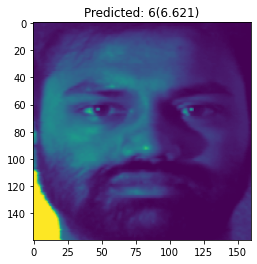

In [53]:

selection = random.randint(1, X_test.shape[0])
random_face_emb = X_test_reshaped[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class]) - 1


samples = np.expand_dims(random_face_emb, axis = 0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

class_index = yhat_class[0]
class_probability = yhat_prob[0, class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)-1
print('Predicted: %s (%.3f)' %(predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

plt.imshow(X_train[selection])
title = 'Predicted: %s(%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show

In [54]:

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_reshaped, y_train)


RandomForestClassifier()

In [55]:
rf_predictions = rfc.predict(X_test_reshaped)
print(classification_report(y_test,rf_predictions))


print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      0.67      0.80         3
           3       0.33      0.33      0.33         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.50      0.67      0.57         3
           7       0.75      1.00      0.86         3
           8       1.00      1.00      1.00         3
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       0.33      0.33      0.33         3
          13       0.67      0.67      0.67         3
          14       0.67      0.67      0.67         3
          15       0.75      1.00      0.86         3

    accuracy                           0.78        45
   macro avg       0.80      0.78      0.77        45
weighted avg       0.80   

In [56]:
y_test


[15,
 9,
 2,
 7,
 3,
 4,
 15,
 3,
 7,
 10,
 12,
 5,
 10,
 11,
 11,
 12,
 1,
 9,
 14,
 12,
 2,
 5,
 2,
 4,
 6,
 8,
 13,
 9,
 15,
 8,
 3,
 14,
 4,
 10,
 6,
 13,
 14,
 11,
 5,
 7,
 6,
 13,
 1,
 8,
 1]

[15,
 9,
 2,
 7,
 3,
 4,
 15,
 3,
 7,
 10,
 12,
 5,
 10,
 11,
 11,
 12,
 1,
 9,
 14,
 12,
 2,
 5,
 2,
 4,
 6,
 8,
 13,
 9,
 15,
 8,
 3,
 14,
 4,
 10,
 6,
 13,
 14,
 11,
 5,
 7,
 6,
 13,
 1,
 8,
 1]

In [60]:
X_test

array([[[  4,   4,   4, ...,  18,  16,  13],
        [  5,   5,   4, ...,  18,  16,  13],
        [  6,   6,   6, ...,  12,  13,  12],
        ...,
        [255, 255, 255, ...,  17,  18,  20],
        [255, 255, 253, ...,  15,  17,  18],
        [255, 255, 250, ...,  15,  17,  18]],

       [[255, 255, 255, ...,  98, 104, 108],
        [255, 255, 249, ...,  86,  97,  97],
        [255, 255, 238, ...,  75,  89,  91],
        ...,
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   3,   2,   1],
        [255, 255, 255, ...,   4,   4,   3]],

       [[ 20,  22,  22, ...,   4,   4,   5],
        [ 22,  20,  19, ...,   5,   5,   5],
        [ 16,  15,  15, ...,   5,   5,   4],
        ...,
        [255, 255, 255, ..., 225, 228, 226],
        [255, 255, 246, ..., 232, 240, 244],
        [255, 255, 243, ..., 232, 236, 239]],

       ...,

       [[ 52,  52,  55, ...,  38,  38,  39],
        [ 45,  46,  49, ...,  39,  38,  39],
        [ 43,  44,  46, ...,  40,  39,  39

In [61]:
X_test_reshaped

array([[0.00020272, 0.00020272, 0.00020272, ..., 0.00076021, 0.00086157,
        0.00091225],
       [0.01270751, 0.01270751, 0.01270751, ..., 0.00019933, 0.00019933,
        0.0001495 ],
       [0.00118342, 0.00130176, 0.00130176, ..., 0.01372765, 0.01396433,
        0.01414185],
       ...,
       [0.00258122, 0.00258122, 0.00273014, ..., 0.01265791, 0.01265791,
        0.01265791],
       [0.00093473, 0.00088554, 0.00088554, ..., 0.01249592, 0.01254511,
        0.01254511],
       [0.0027357 , 0.00284513, 0.00300927, ..., 0.00158671, 0.00158671,
        0.00164142]])

Predicted: 3 (0.000)
Expected: 3


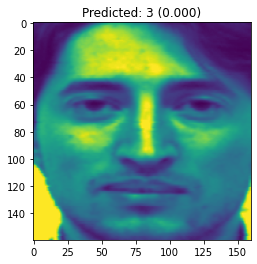

In [62]:

selection = random.randint(1, X_test.shape[0])
random_face_emb = X_test_reshaped[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class]) - 1
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = rfc.predict(samples)
yhat_prob = rfc.predict_proba(samples)
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class) - 1
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
plt.imshow(X_test[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()


In [63]:
TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 15
EPOCHS = 25
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 120
NUMBER_OF_TESTING_IMAGES = 45
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160

In [64]:
import os 

def save_keras_dataset(setname, dataset, labels, per_class):
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])
    j = 0
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [65]:
y_train


[10,
 13,
 1,
 12,
 11,
 9,
 12,
 15,
 6,
 6,
 10,
 1,
 6,
 5,
 1,
 15,
 3,
 2,
 10,
 1,
 10,
 14,
 7,
 2,
 7,
 10,
 10,
 10,
 4,
 3,
 4,
 12,
 4,
 2,
 3,
 14,
 7,
 1,
 5,
 8,
 13,
 3,
 8,
 5,
 3,
 2,
 9,
 4,
 9,
 1,
 6,
 9,
 15,
 15,
 3,
 8,
 7,
 4,
 5,
 6,
 14,
 11,
 6,
 7,
 7,
 13,
 1,
 14,
 12,
 8,
 15,
 7,
 2,
 11,
 11,
 3,
 14,
 9,
 4,
 2,
 6,
 13,
 9,
 11,
 13,
 14,
 5,
 8,
 15,
 1,
 6,
 5,
 13,
 15,
 15,
 14,
 8,
 9,
 4,
 8,
 10,
 2,
 11,
 13,
 12,
 4,
 12,
 7,
 3,
 14,
 5,
 8,
 13,
 12,
 11,
 2,
 5,
 12,
 9,
 11]

NameError: name 'data' is not defined

In [67]:
import shutil
shutil.rmtree(r'data', ignore_errors=True)

save_keras_dataset("test", X_test, y_test, 3)
save_keras_dataset("train", X_train, y_train, 8)

100%|██████████| 120/120 [00:00<00:00, 613.55it/s]


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,)
def add_noise(img):
    VARIABILITY = 35
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)


testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle = False
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)




Found 120 images belonging to 15 classes.
Found 45 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


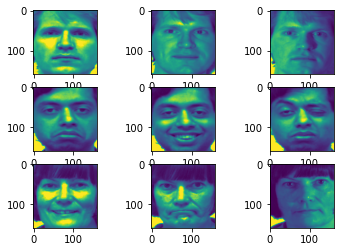

In [69]:
sample_images = testing_generator.next()[0]

f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()

In [70]:
import keras
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints
model = models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MCDropout(rate=0.5))
model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 160, 160, 32)      320       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 80, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 78, 78, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 39, 39, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 18, 18, 128)      0

In [77]:

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, kernel = True)



TypeError: plot_model() got an unexpected keyword argument 'kernel'

In [73]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

model.compile(
loss=losses.CategoricalCrossentropy(from_logits=True),
optimizer=optimizers.Adam(learning_rate=0.0003),
metrics=["accuracy"]
)

history = model.fit(
training_generator,
steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
epochs=EPOCHS,
validation_data=testing_generator,
shuffle=True,
validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
)


Epoch 1/25


C:\Users\65848\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


6/6 [==============================] - 5s 646ms/step - loss: 12.9063 - accuracy: 0.0833 - val_loss: 11.1026 - val_accuracy: 0.1333
Epoch 2/25
6/6 [==============================] - 3s 557ms/step - loss: 10.0416 - accuracy: 0.1167 - val_loss: 8.7566 - val_accuracy: 0.2000
Epoch 3/25
6/6 [==============================] - 3s 534ms/step - loss: 7.9443 - accuracy: 0.3000 - val_loss: 7.0214 - val_accuracy: 0.2667
Epoch 4/25
6/6 [==============================] - 3s 537ms/step - loss: 6.3933 - accuracy: 0.2750 - val_loss: 5.8283 - val_accuracy: 0.3333
Epoch 5/25
6/6 [==============================] - 4s 616ms/step - loss: 5.1790 - accuracy: 0.4000 - val_loss: 4.9271 - val_accuracy: 0.2889
Epoch 6/25
6/6 [==============================] - 4s 729ms/step - loss: 4.3597 - accuracy: 0.4583 - val_loss: 4.4132 - val_accuracy: 0.2889
Epoch 7/25
6/6 [==============================] - 4s 707ms/step - loss: 3.6363 - accuracy: 0.5917 - val_loss: 3.7611 - val_accuracy: 0.5556
Epoch 8/25
6/6 [============

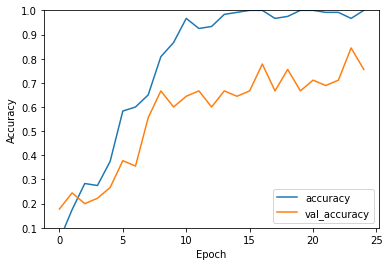

In [ ]:
plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc=' lower right')

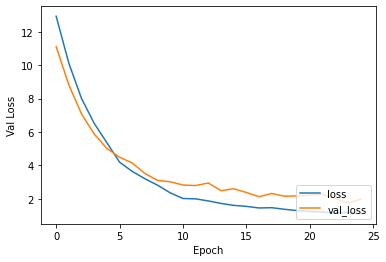

In [ ]:
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_generator.classes, y_pred))
print(validation_generator.classes)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      1.00      0.67         3
           2       1.00      1.00      1.00         3
           3       1.00      0.67      0.80         3
           4       0.43      1.00      0.60         3
           5       1.00      1.00      1.00         3
           6       0.40      0.67      0.50         3
           7       1.00      0.33      0.50         3
           8       1.00      0.33      0.50         3
           9       1.00      0.33      0.50         3
          10       0.50      0.33      0.40         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       0.75      1.00      0.86         3
          14       1.00      0.67      0.80         3

    accuracy                           0.71        45
   macro avg       0.82      0.71      0.71        45
weighted avg       0.82   

In [75]:
MODEL_NAME = "keras_face_recognition.h5"
model_path = "./model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

model.save(os.path.join(model_path, MODEL_NAME))
class_names = training_generator.class_indices
class_names_file_reverse = MODEL_NAME[:-3] + "_class_names_reverse.npy"
class_names_file = MODEL_NAME[:-3] + "_class_names.npy"
np.save(os.path.join(model_path, class_names_file_reverse), class_names)
class_names_reversed = np.load(os.path.join(model_path, class_names_file_reverse), allow_pickle=True).item()
class_names = dict([(value, key) for key, value in class_names_reversed.items()])
np.save(os.path.join(model_path, class_names_file), class_names)

In [ ]:
def get_sample_test_image():
    expected_class = random.randint(1, NUM_CLASSES)
    random_sample = random.randint(1, 3)
    image_path = f"data/train/class_{expected_class}/class_{expected_class}_{random_sample}.png"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return img, expected_class
def preprocess_image(img):
    image = Image.fromarray(img)
    image = image.resize((160,160))
    face_array = np.asarray(image)
    face_array = face_array.reshape(160,160,1)

    face_array = face_array.astype('float32')
    scaled_image = np.expand_dims(face_array, axis=0)

    return scaled_image
def prediction(image, debug=True): 
    plt.imshow(image)
    plt.show()
    input_sample = preprocess_image(img) 
    results = model.predict(input_sample)
    result = np.argmax(results, axis=1)
    index = result[0]
    confidence = results[0][index] * 100
    classes = np.load(os.path.join("model", class_names_file), allow_pickle=True).item()
    if type(classes) is dict:
        for k,  v in classes.items():
            if k == index:
                class_name = v
    if debug:
        print(results)
        print("Detected class is {} with {:.2f}% confidence".format(class_name, round(confidence, 2)))

    return class_name, confidence

img, expected_class = get_sample_test_image()

print(f"Expected class: {expected_class}")

prediction(img), f"expected:{expected_class}"


NameError: name 'random' is not defined

In [ ]:
def monte_carlo_prediction(image, debug=True): 

    plt.imshow(image)
    plt.show()

    input_sample = preprocess_image(img)

    results = np.stack([model(input_sample, training=True) for _ in range(100)])

    results_mean = results.mean(axis=0)
    results_std = results.std(axis=0)
    index = np.argmax(results_mean,axis=1)
    confidence = results_mean[0][index][0] * 100

    classes = np.load(os.path.join("model", class_names_file), allow_pickle=True).item()
    if type(classes) is dict:
        for k, v in classes.items():
            if k == index:
                class_name = v

    if (debug):
        print(f'Mean = {np.round(results_mean[:1],2)}')
        print(f'Std  = {np.round(results_std[:1],2)}')
        print(confidence)
        print("detected class is {} with {:.2f}% confidence".format(class_name, round(confidence, 2)))
        
    return class_name, confidence


THRESHOLD = 80

ALLOWED_USERS = ["class_01", "class_03", "class_05", "class_07", "class_09", "class_11", "class_13", "class_15"]

def authenticate(img, debug=False):
    classname, confidence = monte_carlo_prediction(img, debug)

    if (confidence < THRESHOLD):
        print("Face not recognised")
    elif (classname in ALLOWED_USERS):
        print("Welcome {}".format(classname))
    else:
        print("You are not permitted {}".format(classname))
    return classname, confidence


In [ ]:
img, expected_class = get_sample_test_image()
print(f"expected class {expected_class}")

authenticate(img)

NameError: name 'get_sample_test_image' is not defined